In [1]:
from galileojp.k3s import K3SGateway

import datetime
import json
from collections import defaultdict
import pandas as pd
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np
import json

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
sns.set_theme()
sns.set_context("poster")

time_format = "%-M:%S"
time_form = DateFormatter(time_format)

# Scenario Experiment Analysis

In this notebook, we are going to analyse a scenario experiment.
You can find the configuration in the `evaluation/scenario/main.py` file.
To summarize: we start two Mobilenet functions on a cloud VM.
Two clients start to generate request in `zone-a` (IoT-Box) and one client in `zone-b` (Cloudlet).
Each clients sends in total 60 requests with a static interarrival time of 1.

In parallel we start the `randomscheduler` (see `evaluation/scenario/randomscheduler/main.py`).
This program repeatedly randomly chooses an action.
Whereas an action can be to deploy one function replica (40%), teardown one function replica (50%) or do nothing (10%).

The cluster can have a total number of 10 function replicas running across all clusters and has at least one replica running.
Each node can host up to 4 function replica.
The program selects one action every 5 seconds and chooses randomly where to scale up or down.

We want to focus  mainly on two things: where and when function replicas are scheduled and where requests have been processed.
A deeper analysis is definitely possible but out of scope for this notebook.

In [2]:
gw = K3SGateway.from_env()

In [3]:
exp_id = '202207181846-b0f3'

In [4]:
exp_params = gw.get_exp_params(exp_id)
exp_params

{'app_params': {'edgerun/mobilenet-inference:1.0.0': {'service': {'name': 'mobilenet',
    'location': 'data/pictures/dog.jpg',
    'remote': False}}},
 'profiles': {'zone-a': {'edgerun/mobilenet-inference:1.0.0': ['data/profiles/scenario_profile.pkl',
    'data/profiles/scenario_profile.pkl']},
  'zone-b': {'edgerun/mobilenet-inference:1.0.0': ['data/profiles/scenario_profile.pkl']}},
 'lb_ips': {'zone-a': '10.0.1.2', 'zone-b': '10.0.1.12', 'zone-c': '10.0.3.1'},
 'zone_mapping': {'eb-c-vm-0': 'zone-c'},
 'services': {'eb-c-vm-0': {'edgerun/mobilenet-inference:1.0.0': 2}},
 'app_names': {'edgerun/mobilenet-inference:1.0.0': 'mobilenet'},
 'exp_id': '202207181846-b0f3'}

# Trace analysis

In [5]:
traces = gw.preprocessed_traces(exp_id)
traces

original traces size: 180
after -1 filter traces size: 180


,result,table,_start,_stop,_time,value,_field,_measurement,client,created,...,end,exec,latency,final_ip,final_port,pod_name,pod_image,function,dest_zone,dest_cluster
sent,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:03.825374436,_result,0,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:46:49.362000+00:00,9bfcb96276:1,request_id,traces,galileo-worker-zone-a-q8pgc:mobilenet-zone-a:201,3.822521,...,4.638223,0.721657,145.943165,10.42.27.186,8080,mobilenet-deployment-eb-c-vm-0-0,edgerun/mobilenet-inference:1.0.0,mobilenet,zone-c,Cloud
1970-01-01 00:00:04.825166058,_result,1,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:46:50.362000+00:00,9bfcb96276:2,request_id,traces,galileo-worker-zone-a-q8pgc:mobilenet-zone-a:201,4.824759,...,NaN,NaN,38.453102,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1970-01-01 00:00:05.829557728,_result,2,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:46:51.366000+00:00,9bfcb96276:3,request_id,traces,galileo-worker-zone-a-q8pgc:mobilenet-zone-a:201,5.829224,...,NaN,NaN,170.312881,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1970-01-01 00:00:06.834614586,_result,3,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:46:52.371000+00:00,9bfcb96276:4,request_id,traces,galileo-worker-zone-a-q8pgc:mobilenet-zone-a:201,6.834179,...,7.331043,0.473704,74.560404,10.42.27.186,8080,mobilenet-deployment-eb-c-vm-0-0,edgerun/mobilenet-inference:1.0.0,mobilenet,zone-c,Cloud
1970-01-01 00:00:07.840946507,_result,4,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:46:53.377000+00:00,9bfcb96276:5,request_id,traces,galileo-worker-zone-a-q8pgc:mobilenet-zone-a:201,7.840627,...,8.445747,0.582991,73.318005,10.42.27.186,8080,mobilenet-deployment-eb-c-vm-0-0,edgerun/mobilenet-inference:1.0.0,mobilenet,zone-c,Cloud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:59.089334797,_result,175,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:47:44.626000+00:00,beae778526:56,request_id,traces,galileo-worker-zone-b-rrllh:mobilenet-zone-b:479,59.089106,...,59.433836,0.342963,9.034395,10.42.11.10,8080,mobilenet-deployment-7ec63-eb-b-xeon-0-0,edgerun/mobilenet-inference:1.0.0,mobilenet,zone-b,Cloudlet
1970-01-01 00:01:00.091433357,_result,176,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:47:45.628000+00:00,beae778526:57,request_id,traces,galileo-worker-zone-b-rrllh:mobilenet-zone-b:479,60.091212,...,60.438179,0.345588,7.875681,10.42.11.9,8080,mobilenet-deployment-0f26e-eb-b-xeon-0-0,edgerun/mobilenet-inference:1.0.0,mobilenet,zone-b,Cloudlet
1970-01-01 00:01:01.092747759,_result,177,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:47:46.629000+00:00,beae778526:58,request_id,traces,galileo-worker-zone-b-rrllh:mobilenet-zone-b:479,61.092484,...,61.441222,0.346197,9.925604,10.42.11.10,8080,mobilenet-deployment-7ec63-eb-b-xeon-0-0,edgerun/mobilenet-inference:1.0.0,mobilenet,zone-b,Cloudlet


Due to shutting down of replicas, it can happen that running requests are interrupted.
We filter them out for this analysis.

In [6]:
traces = traces[traces['status'] == 200]

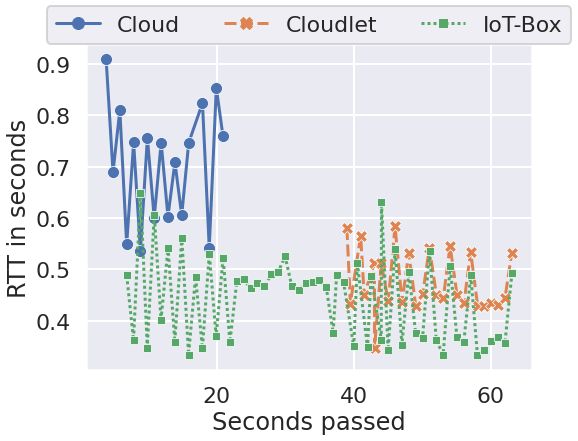

In [7]:
plt.figure(figsize = (8,6))
data = traces.groupby(['dest_cluster']).resample('1S').mean()
g = sns.lineplot(data=data,x='sent',y='rtt',hue='dest_cluster',style='dest_cluster',markers=True,dashes=True)
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           fancybox=True, shadow=False, ncol=5)
g.set_ylabel('RTT in seconds')
g.set_xlabel('Seconds passed')
plt.savefig('figures/scenario-dest-cluster-lineplot.pdf')

We also want to take a look into from where requests were coming from and where they have been processed.

In [8]:
traces['from-to'] = traces['origin_cluster'] + ' -\n' + traces['dest_cluster']
traces.head(5)

/tmp/ipykernel_70023/4157386761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traces['from-to'] = traces['origin_cluster'] + ' -\n' + traces['dest_cluster']


,result,table,_start,_stop,_time,value,_field,_measurement,client,created,...,exec,latency,final_ip,final_port,pod_name,pod_image,function,dest_zone,dest_cluster,from-to
sent,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:03.825374436,_result,0,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:46:49.362000+00:00,9bfcb96276:1,request_id,traces,galileo-worker-zone-a-q8pgc:mobilenet-zone-a:201,3.822521,...,0.721657,145.943165,10.42.27.186,8080,mobilenet-deployment-eb-c-vm-0-0,edgerun/mobilenet-inference:1.0.0,mobilenet,zone-c,Cloud,IoT-Box -\nCloud
1970-01-01 00:00:06.834614586,_result,3,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:46:52.371000+00:00,9bfcb96276:4,request_id,traces,galileo-worker-zone-a-q8pgc:mobilenet-zone-a:201,6.834179,...,0.473704,74.560404,10.42.27.186,8080,mobilenet-deployment-eb-c-vm-0-0,edgerun/mobilenet-inference:1.0.0,mobilenet,zone-c,Cloud,IoT-Box -\nCloud
1970-01-01 00:00:07.840946507,_result,4,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:46:53.377000+00:00,9bfcb96276:5,request_id,traces,galileo-worker-zone-a-q8pgc:mobilenet-zone-a:201,7.840627,...,0.582991,73.318005,10.42.27.186,8080,mobilenet-deployment-eb-c-vm-0-0,edgerun/mobilenet-inference:1.0.0,mobilenet,zone-c,Cloud,IoT-Box -\nCloud
1970-01-01 00:00:08.842485737,_result,5,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:46:54.379000+00:00,9bfcb96276:6,request_id,traces,galileo-worker-zone-a-q8pgc:mobilenet-zone-a:201,8.842184,...,0.461101,74.412346,10.42.27.186,8080,mobilenet-deployment-eb-c-vm-0-0,edgerun/mobilenet-inference:1.0.0,mobilenet,zone-c,Cloud,IoT-Box -\nCloud
1970-01-01 00:00:09.847316574,_result,6,1970-01-01 00:00:00+00:00,2022-07-19 20:26:11.062154+00:00,2022-07-18 18:46:55.384000+00:00,9bfcb96276:7,request_id,traces,galileo-worker-zone-a-q8pgc:mobilenet-zone-a:201,9.847027,...,0.573272,71.390152,10.42.27.186,8080,mobilenet-deployment-eb-c-vm-0-0,edgerun/mobilenet-inference:1.0.0,mobilenet,zone-c,Cloud,IoT-Box -\nCloud


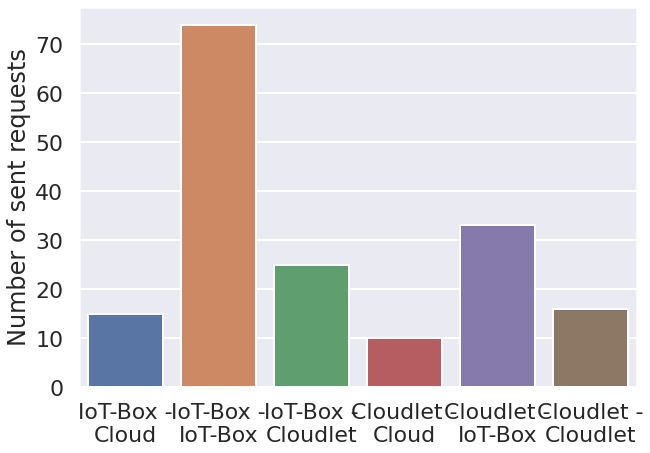

In [9]:
plt.figure(figsize = (10,7))
g = sns.countplot(x='from-to',data=traces)
g.set_xlabel('')
g.set_ylabel('Number of sent requests')
# plt.xticks(rotation=30)
plt.savefig('figures/scenario-from-to-barpot.pdf')

# Scheduling analysis

In the following we focus on the replica scheduling behavior.
While the scheduler chooses random nodes, we want to showcase the ease of use of our framework to create this 
important plot.

In [10]:
replicas = gw.get_replica_schedule_statistics(exp_id, 'mobilenet',per_second=False)

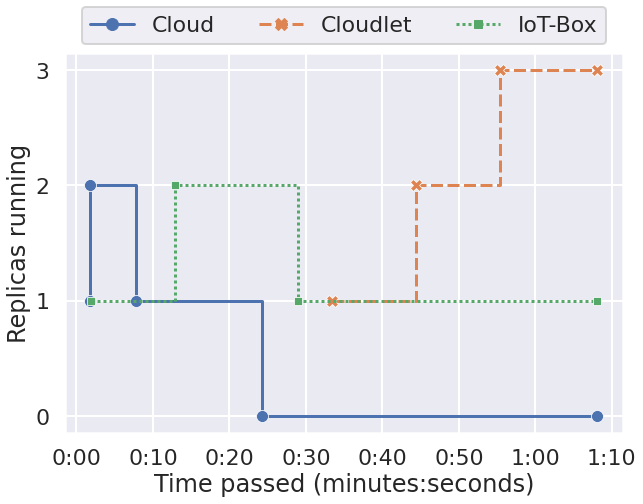

In [11]:
plt.figure(figsize = (10,7))

df = replicas
df = df.sort_values(by='cluster')
g = sns.lineplot(x='ts', y='cluster_total', data=df.reset_index(), style='cluster', hue='cluster', markers=True, drawstyle='steps-post')

g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           fancybox=True, shadow=False, ncol=5)
g.xaxis.set_major_formatter(time_form)
g.set_xlabel('Time passed (minutes:seconds)')
g.set_ylabel('Replicas running')
g.set_yticks([0,1,2,3])

plt.savefig('figures/scenario-replicas-running-lineplot.pdf')

In [12]:
replicas

,cluster,ts,total,cluster_total,exp_id
0,Cloud,1970-01-01 00:00:01.796854,1,1,202207181846-b0f3
1,Cloud,1970-01-01 00:00:01.797679,2,2,202207181846-b0f3
2,IoT-Box,1970-01-01 00:00:01.874834,3,1,202207181846-b0f3
3,Cloud,1970-01-01 00:00:07.726979,2,1,202207181846-b0f3
4,IoT-Box,1970-01-01 00:00:12.886305,3,2,202207181846-b0f3
5,Cloud,1970-01-01 00:00:24.256795,2,0,202207181846-b0f3
6,IoT-Box,1970-01-01 00:00:28.930803,1,1,202207181846-b0f3
7,Cloudlet,1970-01-01 00:00:33.424196,2,1,202207181846-b0f3
8,Cloudlet,1970-01-01 00:00:44.439045,3,2,202207181846-b0f3
9,Cloudlet,1970-01-01 00:00:55.348167,4,3,202207181846-b0f3
